In [7]:
import os
import json
import intake
import warnings
import xesmf as xe
import numpy as np
import xarray as xr
import pandas as pd
import proplot as pplt
from pathlib import Path
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
pplt.rc.update({'reso':'xx-hi','figure.dpi':100})

In [18]:
RAWDIR   = # put/filepath/here
LATRANGE = (5.0,25.0)
LONRANGE = (60.0,90.0)
YEARS    = [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015]
MONTHS   = [6,7,8]

In [19]:
targetlats = np.arange(LATRANGE[0],LATRANGE[1]+1.0,1.0)
targetlons = np.arange(LONRANGE[0],LONRANGE[1]+1.0,1.0)
targetgrid = xr.Dataset({'lat':(['lat'],targetlats),'lon':(['lon'],targetlons)})

In [20]:
imerg = xr.open_dataset(f'{RAWDIR}/IMERG_V06_precipitation_rate.nc').pr
imerg = imerg.sel(time=imerg.time.dt.year.isin(YEARS))
regridder = xe.Regridder(imerg,targetgrid,method='conservative')
imerg     = regridder(imerg)
imergclim = imerg.groupby('time.year').mean('time').mean('year')*24

In [21]:
url = 'https://storage.googleapis.com/cmip6/pangeo-cmip6.json'
cat = intake.open_esm_datastore(url)
print(f'Catalog contains {len(cat.df)} datasets')

query = dict(
    experiment_id='historical',
    table_id='Amon',  
    variable_id='pr',
    grid_label='gn',
    member_id='r1i1p1f1')

subset   = cat.search(**query)
subsetdf = subset.df
print(f'Unique models: {subsetdf.source_id.nunique()}')

Catalog contains 514818 datasets
Unique models: 36


In [22]:
dsdict = subset.to_dataset_dict(
    zarr_kwargs={'consolidated':True},
    storage_options={'token':'anon'})
print(f'Loaded {len(dsdict)} dataset(s)')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


Loaded 36 dataset(s)


In [28]:
cmip6 = []
for key,ds in dsdict.items():
    try:
        pr = ds.pr*3600
        pr = pr.sel(time=pr.time.dt.year.isin(YEARS))
        pr = pr.sel(time=pr.time.dt.month.isin(MONTHS))
        pr = pr.sel(lat=slice(LATRANGE[0]-3,LATRANGE[1]+3),lon=slice(LONRANGE[0]-3,LONRANGE[1]+3))
        regridder = xe.Regridder(pr,targetgrid,method='conservative')
        pr     = regridder(pr)
        prclim = pr.groupby('time.year').mean('time').mean('year')*24
        cmip6.append(prclim)
    except Exception as e:
        continue
print(f'\nSuccessfully processed {len(cmip6)} models')


Successfully processed 34 models


In [29]:
cmip6stack = xr.concat(cmip6,dim='model').squeeze()
cmip6mean  = cmip6stack.mean('model')
cmip6std   = cmip6stack.std('model')
bias       = cmip6mean-imergclim

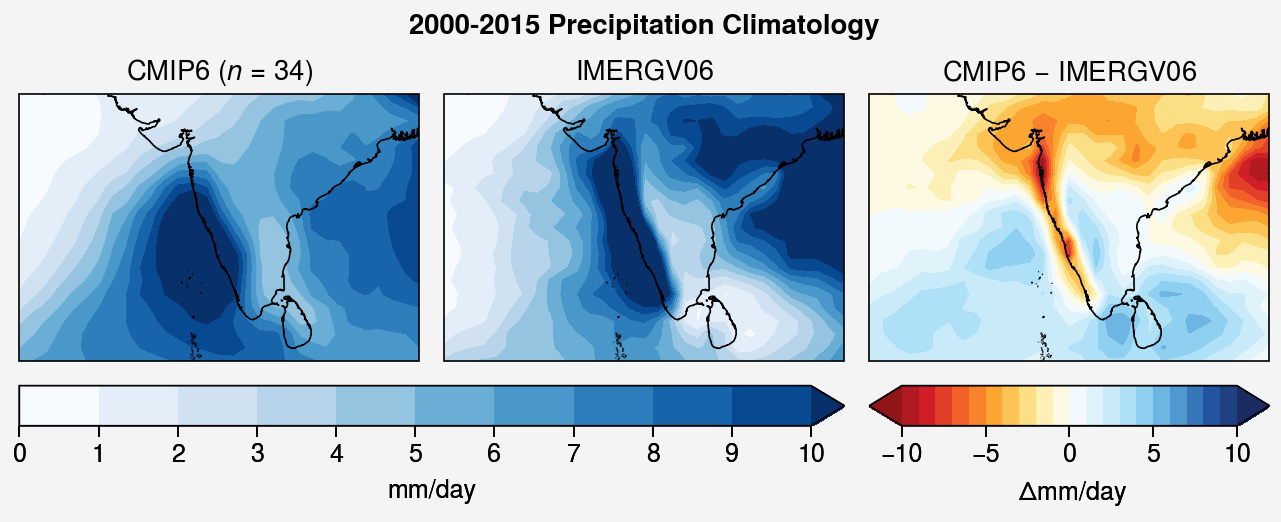

In [33]:
fig,axs = pplt.subplots(nrows=1,ncols=3,refwidth=2,proj='cyl')
axs.format(suptitle='2000-2015 Precipitation Climatology',coast=True,latlim=LATRANGE,lonlim=LONRANGE,grid=False)

m1 = axs[0].contourf(cmip6mean,cmap='Blues',vmin=0,vmax=10,levels=11,extend='max')
axs[0].format(title=r'CMIP6 ($\mathit{n}$ = 34)')

m2 = axs[1].contourf(imergclim,cmap='Blues',vmin=0,vmax=10,levels=11,extend='max')
axs[1].format(title='IMERGV06')
fig.colorbar(m2,cols=(1,2),loc='b',label='mm/day')

m3 = axs[2].contourf(bias,cmap='ColdHot_r',vmin=-10,vmax=10,levels=21,extend='both')
axs[2].format(title='CMIP6 $-$ IMERGV06')
fig.colorbar(m3,cols=3,loc='b',ticks=5,label=' $\Delta$mm/day')

pplt.show()